In [1]:
import os
import statistics
import polars as pl
import pandas as pd
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings("ignore")

# Matriz de confusión

In [2]:
matrix_corr = pd.read_csv('/home/mlia/proyectos/data-generation/docs/notebooks/aux/matrix_corr_emt.csv',index_col=False)

In [3]:
matrix_corr = matrix_corr.rename(index= dict(zip(matrix_corr.index, matrix_corr.columns.to_list())))

<Axes: >

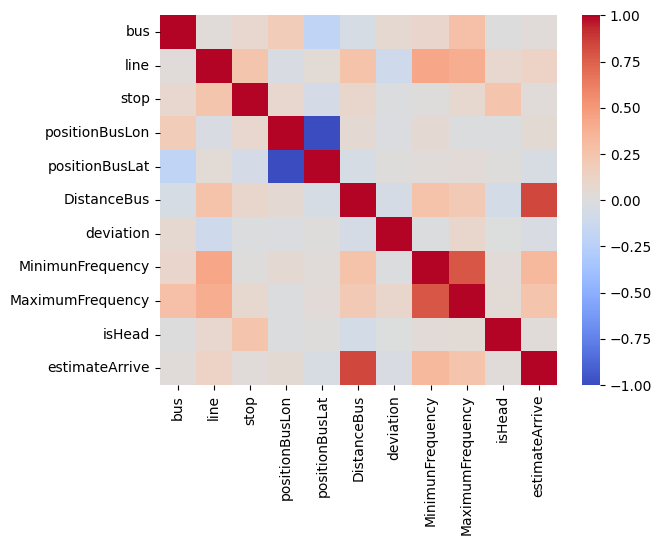

In [4]:
sns.heatmap(matrix_corr, cmap='coolwarm',vmin=-1, vmax=1)

# KPI
(meter explicación)

In [138]:
sample_data_02 = pl.scan_csv('/home/mlia/proyectos/data-generation/data/train/emt/2024/03/03/emt_20240303.csv')
sample_data_aux_02 = pl.scan_csv('/home/mlia/proyectos/data-generation/data/train/emt/2024/03/03/emt_20240303_aux.csv')

In [139]:
sample_data_02.head().collect()

,PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
i64,str,str,str,i64,str,i64,f64,f64,i64,str,f64,i64,str,i64
0,"""2024-03-03 22:…","""2024-03-03""","""2024-03-03 22:…",2331,"""127""",1617,-3.71898,40.465098,3645,"""CUATRO CAMINOS…",null,0,"""FE""",818
1,"""2024-03-03 10:…","""2024-03-03""","""2024-03-03 10:…",2133,"""107""",497,-3.688693,40.467328,2778,"""HORTALEZA""",15.0,0,"""FE""",555
2,"""2024-03-03 20:…","""2024-03-03""","""2024-03-03 20:…",541,"""70""",232,-3.675485,40.467472,6703,"""ALSACIA""",12.0,0,"""FE""",1369
3,"""2024-03-03 13:…","""2024-03-03""","""2024-03-03 13:…",2268,"""175""",4508,-3.696627,40.486987,13206,"""PLAZA CASTILLA…",20.0,1,"""FE""",2318
4,"""2024-03-03 15:…","""2024-03-03""","""2024-03-03 15:…",3273,"""11""",220,-3.669398,40.458809,8153,"""BARRIO BLANCO""",null,0,"""FE""",2399


In [140]:
sample_data_aux_02.head().collect()

,PK,reliable_arrival_date,predict_arrival_date,interval_time,estimateArrive
i64,str,str,str,str,i64
0,"""2024-03-03 13:…","""2024-03-03 13:…","""2024-03-03 14:…","""[12 14]""",2318
1,"""2024-03-03 15:…","""2024-03-03 15:…","""2024-03-03 16:…","""[14 16]""",2399
2,"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 13:…","""[11 13]""",2053
3,"""2024-03-03 13:…","""2024-03-03 13:…","""2024-03-03 13:…","""[12 14]""",56
4,"""2024-03-03 19:…","""2024-03-03 19:…","""2024-03-03 19:…","""[18 20]""",201


In [141]:
def KPI_fun(date_true,date_pred):
    date_true = datetime.strptime(date_true, '%Y-%m-%d %H:%M:%S.%f')
    date_pred = datetime.strptime(date_pred, '%Y-%m-%d %H:%M:%S.%f')
    
    dif = max(date_true,date_pred) - min(date_true,date_pred)
    return dif.total_seconds()

In [142]:
KPI = sample_data_aux_02.with_columns(pl.struct(pl.col('reliable_arrival_date'),pl.col('predict_arrival_date')).alias('struct').map_elements(lambda x: KPI_fun(x['reliable_arrival_date'], x['predict_arrival_date'])).alias('KPI_value')).collect()

In [143]:
dict = KPI.sort('estimateArrive').select('estimateArrive','KPI_value').to_dict()

In [145]:
def plot_KPI(dict):
    new_dict = {}
    MAE = []
    for eta, kpi in zip(dict['estimateArrive'], dict['KPI_value']):
        # Verificar si el entero ya está en el diccionario
        if eta in new_dict:
            # Si el entero ya está en el diccionario, agregar el valor numérico a la lista existente
            new_dict[eta].append(kpi)
        else:
            # Si el entero no está en el diccionario, crear una nueva lista con el valor numérico
            new_dict[eta] = [kpi]
            
    for key,val in zip(new_dict.keys(),new_dict.values()):
        MAE.append((key/60,statistics.mean(val)/60))
        

    # Crear el gráfico de dispersión
    plt.plot([data[0] for data in MAE], [data[1] for data in MAE])
    plt.gca().invert_xaxis()
    # Añadir etiquetas a los ejes
    plt.xlabel('Remaining time (minutes)')
    plt.ylabel('MAE (minutes)')

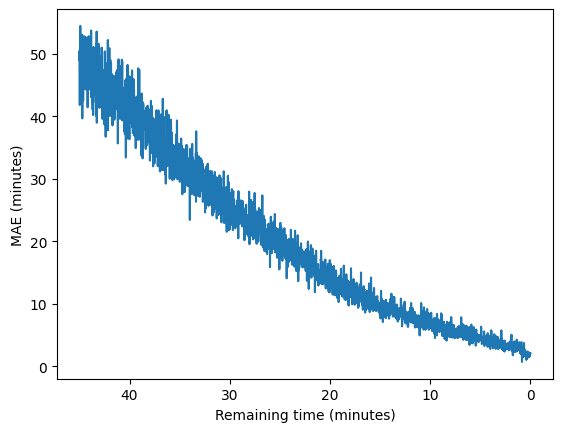

In [146]:
plot_KPI(dict)

# Filtramos
* Bus 51
* Line BR1
* Stop 4366
* Destination VALDEBEBAS


In [147]:
sample_data_02 = sample_data_02.filter(pl.col('bus')==51, pl.col('line')=="BR1",pl.col('stop')==4366, pl.col('destination')=="VALDEBEBAS")

In [149]:
data = sample_data_aux_02.join(sample_data_02,on='PK',how='inner')

In [157]:
sample_data_aux_02_filter = data.filter(pl.col('interval_time')=="[11 13]").select(pl.col('datetime'),pl.col('reliable_arrival_date'),pl.col('predict_arrival_date'),pl.col('interval_time'),pl.col('estimateArrive')).sort('datetime','estimateArrive',descending=True).collect()

In [159]:
KPI_data = sample_data_aux_02_filter.with_columns(pl.struct(reliable_arrival_date = pl.col('reliable_arrival_date'), predict_arrival_date = pl.col('predict_arrival_date').alias('struct')).map_elements(lambda x: KPI_fun(x['reliable_arrival_date'], x['predict_arrival_date'])).alias('KPI_value'))

In [161]:
KPI_data.sort('KPI_value',descending=True)

datetime,reliable_arrival_date,predict_arrival_date,interval_time,estimateArrive,KPI_value
str,str,str,str,i64,f64
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1958,341.567779
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1716,341.148263
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1837,341.135457
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1898,340.938425
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",2061,340.932139
…,…,…,…,…,…
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",175,0.396977
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1180,0.389483
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…","""[11 13]""",1196,0.331104


In [162]:
dict = KPI_data.sort('estimateArrive').select('estimateArrive','KPI_value')

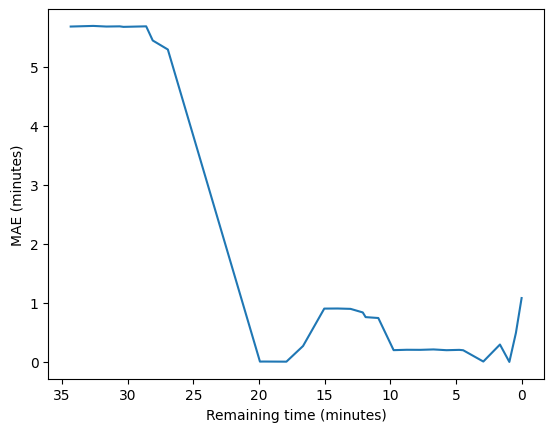

In [163]:
plot_KPI(dict)